In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sklearn.mixture import GaussianMixture

## Подготовим данные

In [4]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../../data/SUSY.csv', header=None, names=column_names)

In [5]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [6]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [7]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

Перемешиваем данные(неясно зачем, если train_test_split сам это умеет)

In [8]:
idx = np.random.permutation(len(labels))
X_data, labels = X_data[idx], labels[idx]

Разбиваем на train(8% от всех данных) и test(2%)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=8e-2, test_size=2e-2, random_state=5)

In [11]:
y_train = labels[indx_train].reset_index(drop=True)
y_test = labels[indx_test].reset_index(drop=True)

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [12]:
y_train.head()

0    1.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: label, dtype: float64

In [13]:
y_test.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64

Разбиваем объекты по классам

In [14]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [15]:
X_good.shape, X_train.shape, X_data.shape

((217106, 18), (400000, 18), (5000000, 18))

Судя по размеру X_good, нельзя сказать, что второй класс - аномалия, поскольку классы сбалансированы

## Сгенерируем примеры используя GMM подход

Обучим смесь на нейтральных примерах

In [16]:
gm = GaussianMixture(n_components=15, n_init=6, covariance_type="full", verbose=0)

In [17]:
%%time
gm.fit(X_good)

CPU times: user 8min 39s, sys: 8.37 s, total: 8min 47s
Wall time: 8min 38s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [18]:
gm.bic(X_good)

2629629.4679599213

Генерируем выборку размера исходной нейтральной следующим образом:
- Для каждой компоненты смеси распределения, сэмплируем свои примеры с востановленными матожиданием и матрицей ковариаций
- Количество примеров для компоненты пропорционально ее вкладу в смесь

In [19]:
from scipy.stats import multivariate_normal

In [20]:
n_samples = X_good.shape[0]

In [21]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                       size=int(gm.weights_[0]*n_samples)))
for d in range(1, gm.n_components):
    gen=np.vstack((
        gen, multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))
    ))
np.random.shuffle(gen)
gen = np.array(gen)

Посчитаем плотности вероятности на сгенерированных объектах для каждой компоненты смеси

In [22]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [23]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True)

In [24]:
gen.shape

(217100, 18)

Выберем для каждого объекта наибольшую вероятность по всем компонентам и инвертируем это значение для получения веса

Т.е. нам интересны те примеры, которые мало вероятно появляются в восстановленной смеси распределения(необычное поведение == аномалия)

In [25]:
maxprob = np.max(probabilities, axis=0)
gen_w = 1./(maxprob + 1e-2)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

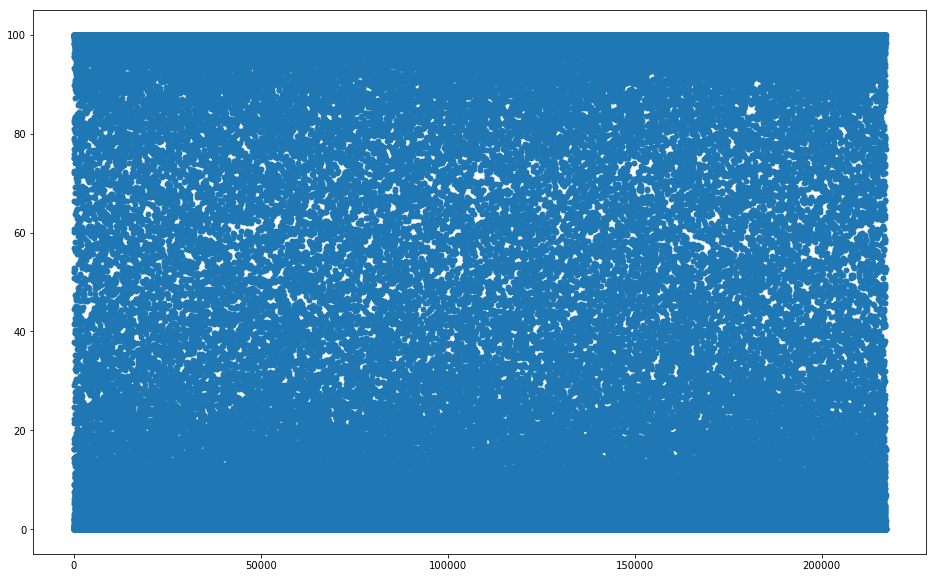

In [26]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(gen_w)), gen_w, linewidths=0.00001)
plt.show()

Нормируем полученные веса

In [27]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [28]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [29]:
gen_w_normed.sum(), np.sum(weights)

(217106.0, 217106.0)

### <font color="red">Посмотрел презентацию, но так и не понял зачем мы объединяем известные по исходным данным нейтральные объекты и сгенерированые?</font>

In [30]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [31]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [32]:
weights_mix.shape

(434206,)

## Обучим на этом нейронку

In [33]:
import tensorflow as tf

In [34]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1013752440600814326
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 202506240
locality {
  bus_id: 1
}
incarnation: 17664395224645676668
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: e5a6:00:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 2779988462350832203
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: f90f:00:00.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 10975674368
locality {
  bus_id: 1
}
incarnation: 220461375478875757
physical_device_desc: "device: 2, name: Tesla K80, pci bus id: 0db9:00:00.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 10537867674
locality {
  bus_id: 1
}
incarnation: 6504140247808218733
physical_device_desc: "device: 3, name: Tesla K80, pci bus id: 1ef0:00:00.0"
]


In [35]:
tf.__version__

'1.2.1'

In [36]:
import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [37]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

In [38]:
keras.__version__

'2.1.5'

In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

tf.set_random_seed(0)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [40]:
K.set_session(sess)

Простейшая сверточная сеть для двухклассовой классификации

In [41]:
def build_net():
#     with tf.device('/gpu:2'):
    net = Sequential()
    net.add(L.Dense(80, input_shape=(X_good.shape[1],), activation = 'relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(32, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    net.add(L.Dense(1, activation='sigmoid'))

    adam = keras.optimizers.Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

Строит зависимость ошибок от эпохи

In [42]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [43]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_10 = {}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall и precision at 10

In [44]:
def p_at_10(y_test, y_pred, n=10):
    ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [45]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [46]:
def _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append(p_at_r(y_test, y_pred, float(recall)))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [p_at_r(y_test, y_pred, float(recall))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = p_at_r(y_test, y_pred, float(recall))

Посмотрим на значения весов объектов в объединенной выборке

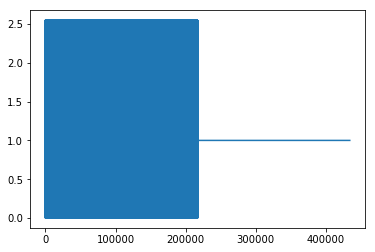

In [47]:
plt.plot(weights_mix)
plt.show()

Обучим нейронку с нашими весами, перемешав данные дважды(видимо я что-то не понимаю, но зачем так делать)?

Train on 390785 samples, validate on 43421 samples
Epoch 1/130
390785/390785 [==============================] - 1s 4us/step - loss: 0.7033 - val_loss: 0.6107
Epoch 2/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.6187 - val_loss: 0.5802
Epoch 3/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.5860 - val_loss: 0.5702
Epoch 4/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.5579 - val_loss: 0.5700
Epoch 5/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.5313 - val_loss: 0.5730
Epoch 6/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.5070 - val_loss: 0.5648
Epoch 7/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.4808 - val_loss: 0.5471
Epoch 8/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.4502 - val_loss: 0.5161
Epoch 9/130
390785/390785 [==============================] - 1s 2us/step - loss: 0.4168 - val

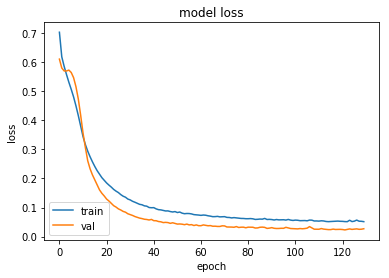

In [48]:
%%time
idx = np.random.permutation(len(y_mix))

net = build_net()
history = net.fit(X_mix[idx], y_mix[idx], 
                  batch_size=10000, epochs=130, validation_split=0.1, verbose=1, shuffle=True, 
                  sample_weight=weights_mix[idx])
history_plot(history)

Посмотрим на результаты

100000/100000 [==============================] - 4s 40us/step

f1_score  0.0012634238787113078
confusion_matrix 
[[54122    24]
 [45825    29]]


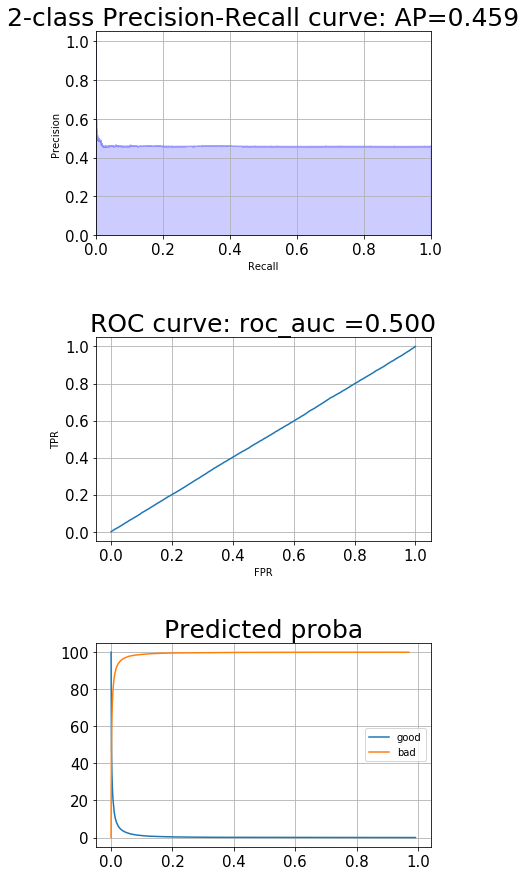

In [49]:
y_pred = net.predict_proba(X_test, verbose=1)
ours_pr_aucs['ours with alpha=0.'] = [average_precision_score(y_test, y_pred)]
ours_roc_aucs['ours with alpha=0.'] = [roc_auc_score(y_test, y_pred)]
ours_p_at_10['ours with alpha=0.'] = [p_at_10(y_test, y_pred)]
_eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr='ours with alpha=0.')

print('')
perfomance(y_test, y_pred)

Похоже алгоритм почти всегда отвечает классом 1 (о чем должен говорить последний график из построения так и не понял?)

## Получим значения при разных долях включения истинных аномалий

Инициализируем веса объектов обратно пропорционально доли класса в выборке

In [50]:
len(y_train)-np.sum(y_train)

217106.0

In [51]:
np.sum(y_train)

182894.0

In [52]:
len(y_train)

400000

In [53]:
len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train))

array([2.18705917, 1.84241799, 2.18705917, ..., 2.18705917, 1.84241799,
       2.18705917])

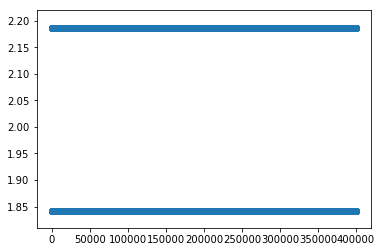

In [54]:
weights_train = np.array(len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train)))
plt.scatter(np.arange(len(y_train)), weights_train.ravel())
plt.show()

Обучим нейронки при разных долях участия аномалий в выборке(10 долей, $\alpha$=1)

In [55]:
import math
n_splits=10
step = math.ceil((X_bad.shape[0]/(n_splits)))

Значения alphas и долей негативных примеров взял из Meeting minutes (29.03.2018)

In [56]:
fraction_of_negative_used = np.array([0, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.

In [57]:
from tqdm import tqdm

4it [49:55, 748.18s/it]

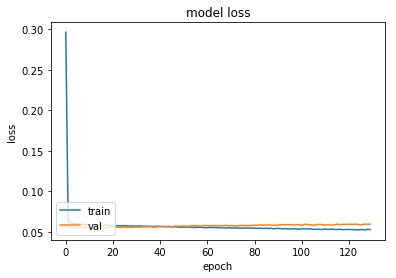

8it [1:40:40, 768.43s/it]

CPU times: user 2h 30min 23s, sys: 39min 56s, total: 3h 10min 19s
Wall time: 1h 40min 40s


In [58]:
%%time
alpha=1
for i, frac in tqdm(enumerate(fraction_of_negative_used)):
    if step*frac > X_bad.shape[0]:
        end_ind = X_bad.shape[0]
    else:   
        end_ind = int(step * frac)

    cur_X = np.concatenate((X_good, X_bad[:end_ind]))
    cur_y = np.concatenate(
        (np.zeros((X_good.shape[0], 1)), np.ones((end_ind, 1)))
    ).ravel()
    cur_w = np.concatenate(
        (np.min(weights_train)*np.ones((X_good.shape[0], 1)), np.max(weights_train)*np.ones((end_ind, 1)))
    ).ravel()
    
    idx = np.random.permutation(len(cur_y))
    cur_X, cur_y, cur_w = cur_X[idx], cur_y[idx], cur_w[idx]

    net = build_net()
    history = net.fit(cur_X, cur_y, 
                      batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                      sample_weight=cur_w)
    if i==4:
        history_plot(history)

    y_pred=net.predict_proba(X_test)
    if alpha in ours_pr_aucs:
        # append the new number to the existing array at this slot
        ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
        ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
        ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
    else:
        # create a new array in this slot
        ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
        ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
        ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
    _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

In [59]:
ours_pr_aucs, ours_roc_aucs, ours_p_at_10, ours_p_at_r

({'ours with alpha=0.': [0.459473337196837],
  1: [0.4585492598040217,
   0.4600237044906517,
   0.4594207376680656,
   0.45989772415926944,
   0.4598359278575974,
   0.4588460520761314,
   0.4572877373615132,
   0.4573060114407239]},
 {'ours with alpha=0.': [0.49962441397324037],
  1: [0.5002494574008366,
   0.5016044529797101,
   0.5018099376359861,
   0.5001629743671588,
   0.5019938298283881,
   0.49997221072857284,
   0.49876600559207196,
   0.4990466697621154]},
 {'ours with alpha=0.': [0.3], 1: [0.3, 0.4, 0.3, 0.4, 0.8, 0.6, 0.3, 0.6]},
 {'0.8': {'ours with alpha=0.': [0.45855961274965745],
   1: [0.4599694271678122,
    0.4592892820860142,
    0.45931998320946194,
    0.4588316848073501,
    0.4598072306773734,
    0.45897968777060294,
    0.4588558352402746,
    0.4587286324786325]},
  '0.9': {'ours with alpha=0.': [0.45855961274965745],
   1: [0.4595611007875409,
    0.4592892820860142,
    0.45892446759613914,
    0.4588316848073501,
    0.45925571776426244,
    0.4588761122

Обучим нейронки при разных долях участия аномалий в выборке(4 $\alpha$ * 8 долей)

In [60]:
points_cnt = 10
alphas = np.exp([np.log(0.05) * (points_cnt - i) * 1/points_cnt for i in range(points_cnt)]) # log scale
# alphas = [0.05, 0.1, 0.3, 0.5, 0.9]
# alphas = [0, 0.1, 0.25, 0.5]

In [61]:
print(alphas)

[0.05       0.06746414 0.09102821 0.1228228  0.1657227  0.2236068
 0.30170882 0.40709053 0.54928027 0.74113445]


In [62]:
points_cnt = 10
# alphas = np.exp([np.log(0.05) * (points_cnt - i) * 1/points_cnt for i in range(points_cnt)]) # log scale
# alphas = [0.05, 0.1, 0.3, 0.5, 0.9]
alphas = [0, 0.1, 0.25, 0.5]

In [63]:
print(alphas)

[0, 0.1, 0.25, 0.5]


Функция обновления весов

Вклад нейтральных и отрицательных объектов одинаковый

В отрицательных вклад истинных аномалий=$\alpha$, а сгенерированных=$(1 - \alpha)$

In [64]:
def upd_weights(alpha, y_mix, num_true_bad, w_g=gen_w_normed):
    # sum of weights for good and bad data: beta * bad + (1 - beta) * good
    # proportion of weights between real and fake data id alpha: alpha * true + (1 - alpha) * fake
    num_good = len(y_mix)-np.sum(y_mix)
    num_fake_bad = np.sum(y_mix)
    sum_w = num_good+num_fake_bad+num_true_bad
    
    beta = 0.5
    w_good = (1-beta)/num_good * np.ones((int(num_good),1))
    
    w_fake_bad = (1-alpha)*beta/num_fake_bad * w_g
    w_fake_bad = w_fake_bad.reshape(-1,1)
    
    if num_true_bad!=0:
        w_true_bad = alpha*beta/num_true_bad *np.ones((int(num_true_bad),1))
    else:
        w_true_bad=np.empty((0,1))
                           
    return sum_w*np.vstack((w_fake_bad, w_good, w_true_bad))

  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]

0


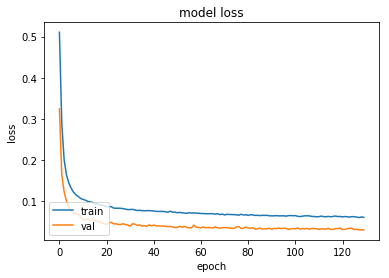

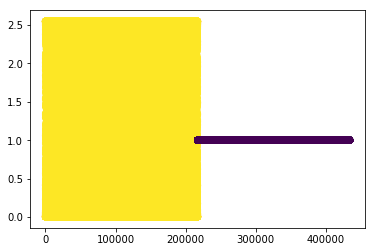


1it [25:13, 1513.55s/it]
2it [50:07, 1507.71s/it]
3it [1:16:49, 1535.97s/it]

0


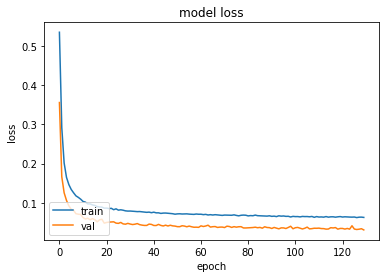

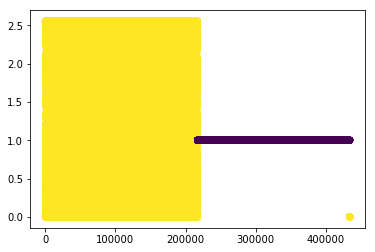


4it [1:42:19, 1534.28s/it]
5it [2:07:31, 1527.39s/it]
6it [2:32:56, 1526.91s/it]

0


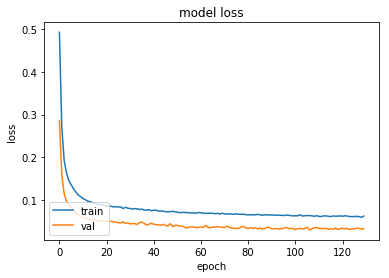

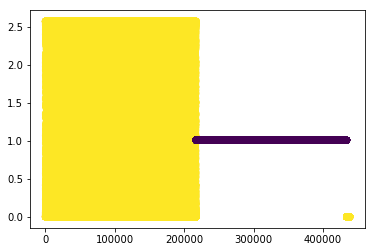


7it [2:59:04, 1539.19s/it]
8it [3:25:05, 1545.65s/it]
 25%|██▌       | 1/4 [3:25:05<10:15:16, 12305.55s/it]
0it [00:00, ?it/s]

0.1


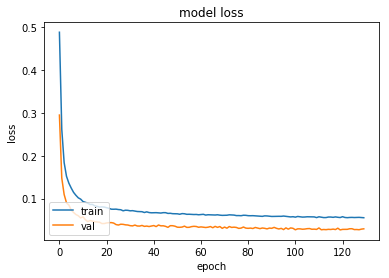

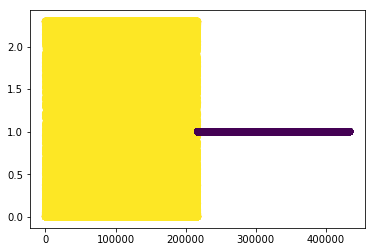


1it [25:41, 1541.83s/it]
2it [51:22, 1541.60s/it]
3it [1:16:26, 1530.18s/it]

0.1


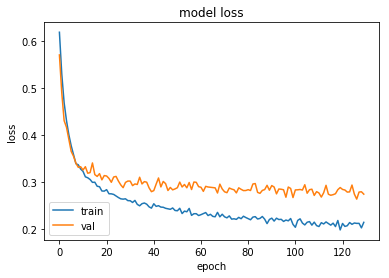

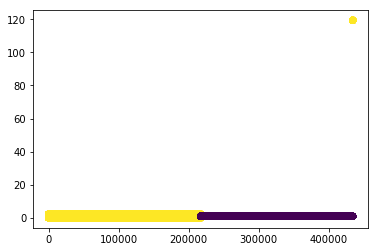


4it [1:43:06, 1551.00s/it]
5it [2:08:37, 1545.15s/it]
6it [2:35:05, 1558.08s/it]

0.1


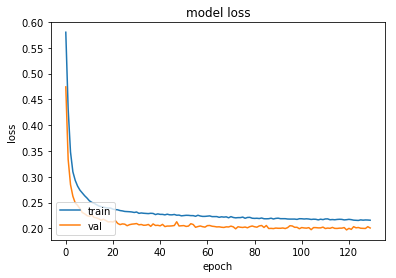

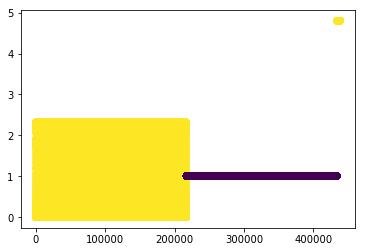


7it [3:01:31, 1566.37s/it]
8it [3:28:50, 1588.09s/it]
 50%|█████     | 2/4 [6:53:55<6:52:25, 12372.97s/it] 
0it [00:00, ?it/s]

0.25


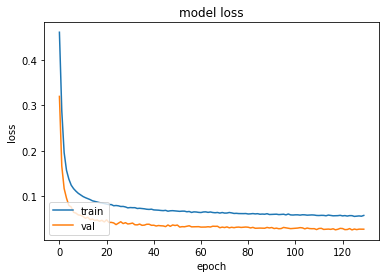

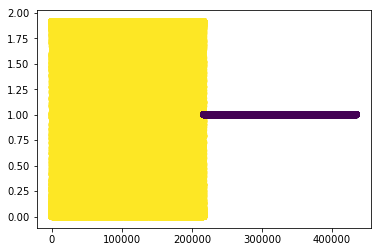


1it [27:19, 1639.41s/it]
2it [53:36, 1620.80s/it]
3it [1:19:18, 1597.01s/it]

0.25


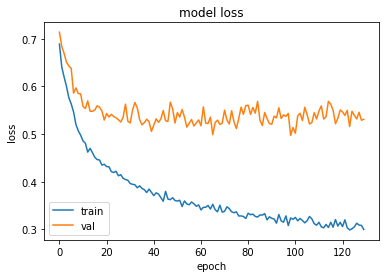

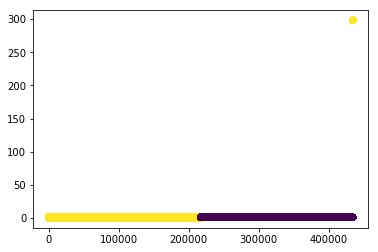


4it [1:45:43, 1593.45s/it]
5it [2:11:15, 1574.98s/it]
6it [2:37:42, 1578.62s/it]

0.25


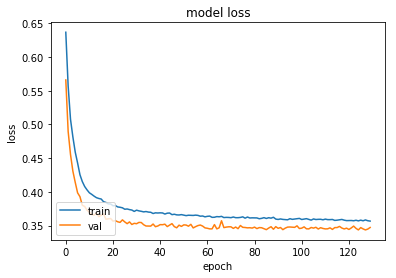

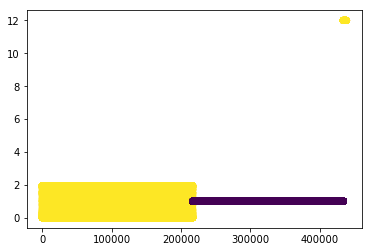


7it [3:04:37, 1589.66s/it]
8it [3:31:47, 1601.78s/it]
 75%|███████▌  | 3/4 [10:25:43<3:27:53, 12473.44s/it]
0it [00:00, ?it/s]

0.5


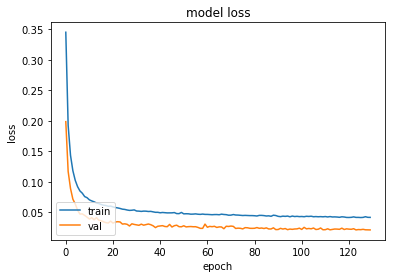

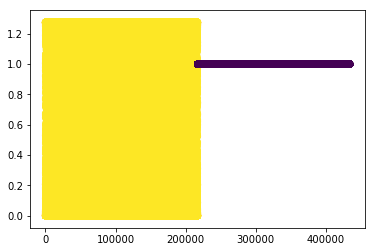


1it [26:29, 1589.95s/it]
2it [52:45, 1585.60s/it]
3it [1:18:58, 1581.91s/it]

0.5


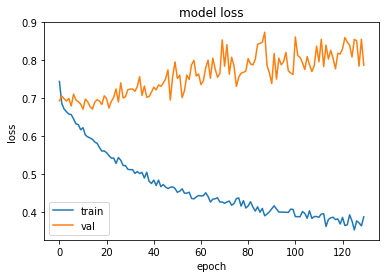

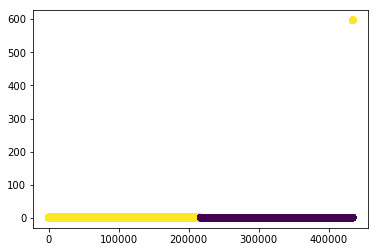


4it [1:45:46, 1589.62s/it]
5it [2:11:38, 1578.32s/it]
6it [2:38:10, 1582.51s/it]

0.5


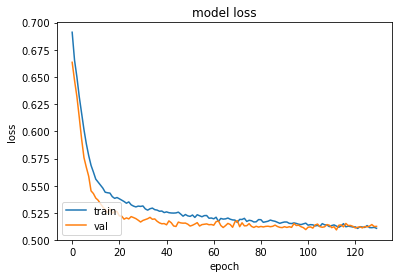

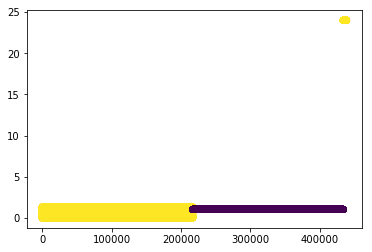


7it [3:05:14, 1594.91s/it]
8it [3:32:20, 1604.30s/it]
100%|██████████| 4/4 [13:58:04<00:00, 12553.60s/it]  

CPU times: user 20h 37min 2s, sys: 5h 22min 59s, total: 1d 2h 2s
Wall time: 13h 58min 4s


In [65]:
%%time
for alpha in tqdm(alphas):
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if step*frac > X_bad.shape[0]:
            end_ind = X_bad.shape[0]
        else:   
            end_ind = int(step * frac)
            
        cur_X = np.concatenate((X_mix, X_bad[:end_ind]))
        cur_y = np.concatenate((y_mix, np.ones((end_ind,1)))).ravel()
        cur_w = upd_weights(alpha, y_mix, w_g=gen_w_normed, num_true_bad=end_ind).ravel()
        
        idx = np.random.permutation(len(cur_y))    
    
        net = build_net()
        history = net.fit(cur_X[idx], cur_y[idx], 
                          batch_size=256, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w[idx])
        if i%3==0:
            print(alpha)
            history_plot(history)
            
            plt.scatter(np.arange(len(cur_w)), cur_w, c=cur_y)#np.concatenate((y_mix, 2*np.ones((end_ind,1)))).ravel())
            plt.show()

        y_pred=net.predict_proba(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append(average_precision_score(y_test, y_pred))
            ours_roc_aucs[alpha].append(roc_auc_score(y_test, y_pred))
            ours_p_at_10[alpha].append(p_at_10(y_test, y_pred))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [average_precision_score(y_test, y_pred)]
            ours_roc_aucs[alpha] = [roc_auc_score(y_test, y_pred)]
            ours_p_at_10[alpha] = [p_at_10(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, ours_p_at_r, descr=alpha)

In [66]:
ours_pr_aucs

{'ours with alpha=0.': [0.459473337196837],
 1: [0.4585492598040217,
  0.4600237044906517,
  0.4594207376680656,
  0.45989772415926944,
  0.4598359278575974,
  0.4588460520761314,
  0.4572877373615132,
  0.4573060114407239],
 0: [0.4592829700721417,
  0.4613409863099982,
  0.45940567388656056,
  0.45730651562865016,
  0.45916927409324015,
  0.4602917651966551,
  0.4602101799381676,
  0.4601076670572068],
 0.1: [0.45932102041407286,
  0.4593946276916967,
  0.4575835591626763,
  0.45833468679150413,
  0.4596700332686598,
  0.4585729155868201,
  0.460303577481914,
  0.46108089224376236],
 0.25: [0.4591286772884681,
  0.4598820900065419,
  0.45597628521192346,
  0.45962046021978764,
  0.45755205340927385,
  0.4585862280630752,
  0.4588905592917125,
  0.45926660933009394],
 0.5: [0.4584017417157148,
  0.45997050426807956,
  0.45955608941260156,
  0.4583925855628769,
  0.4593656895184918,
  0.45897855041407,
  0.4576362934677087,
  0.45806038578588604]}

# Classic methods

## Unsupervised

In [67]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [68]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_10 = {}
unsupervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [69]:
def p_at_10_un(y_test, y_pred, n=10):
    try:
        ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    except:
        ind = np.argpartition(y_pred, -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

0it [00:00, ?it/s]

One-Class SVM
recall_score  0.03035722074410084
precision_score  0.46123260437375746
f1_score  0.056965133409723354
confusion_matrix 
[[52520  1626]
 [44462  1392]]


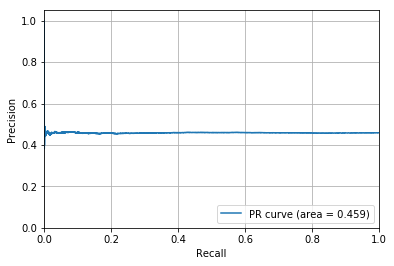

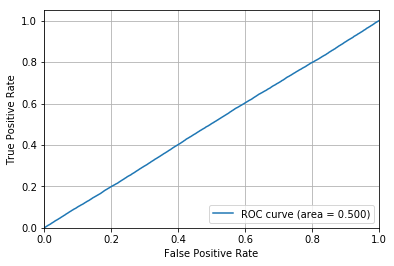

1it [05:09, 309.19s/it]

Precision at 10:  0.0
Precision at recall:  0.8 = 0.4587398476517177; 0.9 = 0.4587398476517177; 0.95 = 0.4587398476517177; 0.99 = 0.4587398476517177
Isolation Forest
recall_score  0.030291795699393727
precision_score  0.4508276533592989
f1_score  0.05676918361091243
confusion_matrix 
[[52454  1692]
 [44465  1389]]


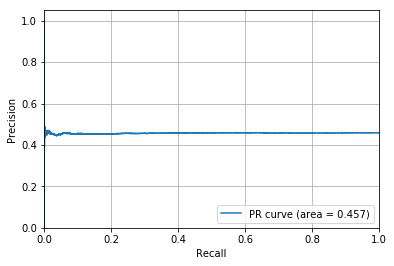

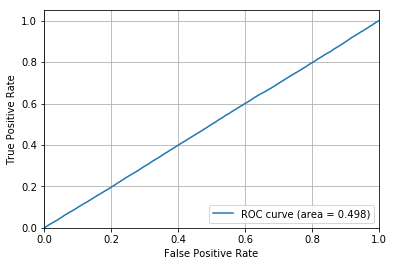

2it [07:16, 254.62s/it]

Precision at 10:  0.0
Precision at recall:  0.8 = 0.45879348286931415; 0.9 = 0.45879348286931415; 0.95 = 0.45879348286931415; 0.99 = 0.45879348286931415


In [71]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor


classifiers_classic_uns = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)
}


for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
#         y_pred = clf.decision_function(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        

        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=pr_auc      
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=roc_auc
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        unsupervised_p_at_10[clf_name] = p_at_10_un(-y_test_rescale, -Score)
        _eval_p_at_rs_flatten(-y_test_rescale, -Score, unsupervised_p_at_r, descr=clf_name)
        
        print("Precision at 10: ", unsupervised_p_at_10[clf_name])
        print("Precision at recall: ", "; ".join(
            map(lambda k: "{} = {}".format(k, unsupervised_p_at_r[k][clf_name]), unsupervised_p_at_r.keys())
        ))

## Supervised

In [72]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

In [73]:
classifiers_classic_sup = {
    "XGBClassifier": xgb.XGBClassifier(n_estimators=60, max_depth=10, nthread=-1, seed=111)
}

In [116]:
supervised_pr_aucs = {}
supervised_roc_aucs = {}
supervised_p_at_10 = {}
supervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [117]:
%%time
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_sup.items())):
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if step*frac > X_bad.shape[0]:
            end_ind = X_bad.shape[0]
        else:   
            end_ind = int(step * frac)
            
        clf.fit(np.concatenate((X_good, X_bad[:end_ind])), 
                np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()) 
        y_pred = clf.predict_proba(X_test)[:,1]
        if clf_name in supervised_pr_aucs:
            # append the new number to the existing array at this slot
            supervised_pr_aucs[clf_name].append(average_precision_score(y_test, y_pred))
            supervised_roc_aucs[clf_name].append(roc_auc_score(y_test, y_pred))
            supervised_p_at_10[clf_name].append(p_at_10_un(y_test, y_pred))
        else:
            # create a new array in this slot
            supervised_pr_aucs[clf_name] = [average_precision_score(y_test, y_pred)]
            supervised_roc_aucs[clf_name] = [roc_auc_score(y_test, y_pred)]
            supervised_p_at_10[clf_name] = [p_at_10_un(y_test, y_pred)]
        _eval_p_at_rs(y_test, y_pred, supervised_p_at_r, descr=clf_name)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:06,  6.54s/it]
2it [00:17,  7.78s/it]
3it [00:42, 13.08s/it]
4it [01:12, 18.19s/it]
5it [01:59, 26.78s/it]
6it [02:48, 33.54s/it]
7it [03:45, 40.34s/it]
8it [04:51, 48.04s/it]
1it [04:51, 291.14s/it]

CPU times: user 4min 54s, sys: 1.14 s, total: 4min 55s
Wall time: 4min 51s


## All together

In [100]:
print(ours_pr_aucs)
print(ours_roc_aucs)
print(ours_p_at_10)
print(ours_p_at_r)

{'ours with alpha=0.': array([0.45947334, 0.45947334, 0.45947334, 0.45947334, 0.45947334,
       0.45947334, 0.45947334, 0.45947334, 0.45947334, 0.45947334,
       0.45947334]), 1: [0.5, 0.4585492598040217, 0.4600237044906517, 0.4594207376680656, 0.45989772415926944, 0.4598359278575974, 0.4588460520761314, 0.4572877373615132, 0.4573060114407239], 0: [0.4592829700721417, 0.4613409863099982, 0.45940567388656056, 0.45730651562865016, 0.45916927409324015, 0.4602917651966551, 0.4602101799381676, 0.4601076670572068], 0.1: [0.45932102041407286, 0.4593946276916967, 0.4575835591626763, 0.45833468679150413, 0.4596700332686598, 0.4585729155868201, 0.460303577481914, 0.46108089224376236], 0.25: [0.4591286772884681, 0.4598820900065419, 0.45597628521192346, 0.45962046021978764, 0.45755205340927385, 0.4585862280630752, 0.4588905592917125, 0.45926660933009394], 0.5: [0.4584017417157148, 0.45997050426807956, 0.45955608941260156, 0.4583925855628769, 0.4593656895184918, 0.45897855041407, 0.45763629346770

import json

def dump(saved_dict, path):
    with open(path, 'w', encoding="utf-8") as file:
        # writing
        json.dump(saved_dict, file, indent=4, ensure_ascii=False)
        
dump(ours_pr_aucs, "./ours_pr_aucs.json")
dump(ours_roc_aucs, "./ours_roc_aucs.json")
dump(ours_p_at_10, "./ours_p_at_10.json")
dump(ours_p_at_r, "./ours_p_at_r.json")

In [118]:
supervised_pr_aucs['XGBClassifier'].insert(0, 0.5), supervised_roc_aucs['XGBClassifier'].insert(0, 0.5)
supervised_pr_aucs, supervised_roc_aucs

({'XGBClassifier': [0.5,
   0.72927,
   0.4516941603050247,
   0.4587445418775752,
   0.45689659168035984,
   0.4602098450262674,
   0.45992605249024043,
   0.45864262477351403,
   0.45807097009026054]},
 {'XGBClassifier': [0.5,
   0.5,
   0.4995730488003651,
   0.49993216055453393,
   0.49959143965082115,
   0.501669793241473,
   0.499891982501232,
   0.5006651592530362,
   0.50015264937534]})

In [119]:
supervised_p_at_10['XGBClassifier'].insert(0, 0.5)
for k in supervised_p_at_r.keys():
    supervised_p_at_r[k]['XGBClassifier'].insert(0, 0.5)
supervised_p_at_10, supervised_p_at_r

({'XGBClassifier': [0.5, 0.5, 0.6, 0.2, 0.4, 0.7, 0.5, 0.3, 0.5]},
 {'0.8': {'XGBClassifier': [0.5,
    0.45854,
    0.45854,
    0.4586267605633803,
    0.4592805049686527,
    0.45937935843793587,
    0.45889012139621194,
    0.4593875556520795,
    0.4594435400959561]},
  '0.9': {'XGBClassifier': [0.5,
    0.45854,
    0.45854,
    0.45857197403589156,
    0.4592805049686527,
    0.4592688191183997,
    0.45889012139621194,
    0.4593875556520795,
    0.4594435400959561]},
  '0.95': {'XGBClassifier': [0.5,
    0.45854,
    0.45854,
    0.45857197403589156,
    0.45891745573659987,
    0.45914527758508333,
    0.45889012139621194,
    0.45928995061065075,
    0.45915294216755825]},
  '0.99': {'XGBClassifier': [0.5,
    0.45854,
    0.45854,
    0.45857197403589156,
    0.45854,
    0.45865556216537773,
    0.4586751808592329,
    0.45875647982538575,
    0.45861981927406736]}})

In [144]:
unsupervised_roc_aucs['Isolation Forest'] = np.ones((8))*unsupervised_roc_aucs['Isolation Forest']
unsupervised_pr_aucs['Isolation Forest'] = np.ones((8))*unsupervised_pr_aucs['Isolation Forest']
unsupervised_roc_aucs['One-Class SVM'] = np.ones((8))*unsupervised_roc_aucs['One-Class SVM']
unsupervised_pr_aucs['One-Class SVM'] = np.ones((8))*unsupervised_pr_aucs['One-Class SVM']

unsupervised_pr_aucs, unsupervised_roc_aucs 

({'Isolation Forest': array([0.45691235, 0.45691235, 0.45691235, 0.45691235, 0.45691235,
         0.45691235, 0.45691235, 0.45691235]),
  'One-Class SVM': array([0.45855193, 0.45855193, 0.45855193, 0.45855193, 0.45855193,
         0.45855193, 0.45855193, 0.45855193])},
 {'Isolation Forest': array([0.49829962, 0.49829962, 0.49829962, 0.49829962, 0.49829962,
         0.49829962, 0.49829962, 0.49829962]),
  'One-Class SVM': array([0.50011962, 0.50011962, 0.50011962, 0.50011962, 0.50011962,
         0.50011962, 0.50011962, 0.50011962])})

In [146]:
unsupervised_p_at_10['Isolation Forest'] = np.ones((8))*unsupervised_p_at_10['Isolation Forest']
unsupervised_p_at_10['One-Class SVM'] = np.ones((8))*unsupervised_p_at_10['One-Class SVM']
for k in unsupervised_p_at_r.keys():
    unsupervised_p_at_r[k]['Isolation Forest'] = np.ones((8))*unsupervised_p_at_r[k]['Isolation Forest']
    unsupervised_p_at_r[k]['One-Class SVM'] = np.ones((8))*unsupervised_p_at_r[k]['One-Class SVM']

unsupervised_p_at_10 , unsupervised_p_at_r

({'Isolation Forest': array([0., 0., 0., 0., 0., 0., 0., 0.]),
  'One-Class SVM': array([0., 0., 0., 0., 0., 0., 0., 0.])},
 {'0.8': {'Isolation Forest': array([0.45879348, 0.45879348, 0.45879348, 0.45879348, 0.45879348,
          0.45879348, 0.45879348, 0.45879348]),
   'One-Class SVM': array([0.45873985, 0.45873985, 0.45873985, 0.45873985, 0.45873985,
          0.45873985, 0.45873985, 0.45873985])},
  '0.9': {'Isolation Forest': array([0.45879348, 0.45879348, 0.45879348, 0.45879348, 0.45879348,
          0.45879348, 0.45879348, 0.45879348]),
   'One-Class SVM': array([0.45873985, 0.45873985, 0.45873985, 0.45873985, 0.45873985,
          0.45873985, 0.45873985, 0.45873985])},
  '0.95': {'Isolation Forest': array([0.45879348, 0.45879348, 0.45879348, 0.45879348, 0.45879348,
          0.45879348, 0.45879348, 0.45879348]),
   'One-Class SVM': array([0.45873985, 0.45873985, 0.45873985, 0.45873985, 0.45873985,
          0.45873985, 0.45873985, 0.45873985])},
  '0.99': {'Isolation Forest': a

In [80]:
ours_pr_aucs

{'ours with alpha=0.': [0.459473337196837],
 1: [0.4585492598040217,
  0.4600237044906517,
  0.4594207376680656,
  0.45989772415926944,
  0.4598359278575974,
  0.4588460520761314,
  0.4572877373615132,
  0.4573060114407239],
 0: [0.4592829700721417,
  0.4613409863099982,
  0.45940567388656056,
  0.45730651562865016,
  0.45916927409324015,
  0.4602917651966551,
  0.4602101799381676,
  0.4601076670572068],
 0.1: [0.45932102041407286,
  0.4593946276916967,
  0.4575835591626763,
  0.45833468679150413,
  0.4596700332686598,
  0.4585729155868201,
  0.460303577481914,
  0.46108089224376236],
 0.25: [0.4591286772884681,
  0.4598820900065419,
  0.45597628521192346,
  0.45962046021978764,
  0.45755205340927385,
  0.4585862280630752,
  0.4588905592917125,
  0.45926660933009394],
 0.5: [0.4584017417157148,
  0.45997050426807956,
  0.45955608941260156,
  0.4583925855628769,
  0.4593656895184918,
  0.45897855041407,
  0.4576362934677087,
  0.45806038578588604]}

In [148]:
ours_pr_aucs['ours with alpha=0.'] = np.ones((8))*ours_pr_aucs['ours with alpha=0.']
ours_roc_aucs['ours with alpha=0.'] = np.ones((8))*ours_roc_aucs['ours with alpha=0.']

In [150]:
ours_p_at_10['ours with alpha=0.'] = np.ones((8))*ours_p_at_10['ours with alpha=0.']
for k in ours_p_at_r.keys():
    ours_p_at_r[k]['ours with alpha=0.'] = np.ones((8))*ours_p_at_r[k]['ours with alpha=0.']

In [83]:
ours_pr_aucs[1.0].insert(0, 0.5)
ours_roc_aucs[1.0].insert(0, 0.5)

In [84]:
ours_p_at_10[1.0].insert(0, 0.5)
for k in ours_p_at_r.keys():
    ours_p_at_r[k][1.0].insert(0, 0.5)

In [85]:
#ours_pr_aucs, ours_roc_aucs 

In [151]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [152]:
pr_s = {k: v for d in (unsupervised_pr_aucs, ours_pr_aucs, supervised_pr_aucs) for k, v in d.items()}
roc_s = {k: v for d in (unsupervised_roc_aucs, ours_roc_aucs, supervised_roc_aucs) for k, v in d.items()}

In [153]:
p_at_10_s = {k: v for d in (unsupervised_p_at_10, ours_p_at_10, supervised_p_at_10) for k, v in d.items()}
p_at_r_s = {}
for key in ours_p_at_r.keys():
    p_at_r_s[key] = {k: v for d in (unsupervised_p_at_r[key], ours_p_at_r[key], supervised_p_at_r[key])
                     for k, v in d.items()}

In [154]:
roc_s

{'One-Class SVM': array([0.50011962, 0.50011962, 0.50011962, 0.50011962, 0.50011962,
        0.50011962, 0.50011962, 0.50011962]),
 'Isolation Forest': array([0.49829962, 0.49829962, 0.49829962, 0.49829962, 0.49829962,
        0.49829962, 0.49829962, 0.49829962]),
 'ours with alpha=0.': array([0.49962441, 0.49962441, 0.49962441, 0.49962441, 0.49962441,
        0.49962441, 0.49962441, 0.49962441]),
 1: [0.5002494574008366,
  0.5016044529797101,
  0.5018099376359861,
  0.5001629743671588,
  0.5019938298283881,
  0.49997221072857284,
  0.49876600559207196,
  0.4990466697621154],
 0: [0.4993893221461585,
  0.5020248056093833,
  0.5010380592111228,
  0.49929946511378875,
  0.4997598215990277,
  0.50026781965467,
  0.5003961212211377,
  0.5002671079612608],
 0.1: [0.5001143246651182,
  0.500454508475927,
  0.49898045186597884,
  0.4992497754613336,
  0.5013579651971565,
  0.5002580045688252,
  0.5013970457040292,
  0.5024120342878305],
 0.25: [0.499426297579119,
  0.5006552301834706,
  0.497

In [161]:
def plot_for_comparison(dic, names, ylabel="PR AUC", y_lim=(0.3,1.0)):
    plt.figure(figsize=(9,9))
    for i, name in enumerate(names):
        plt.plot(fraction_of_negative_used, dic[name], label=name)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0,1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [156]:
pr_s

{'One-Class SVM': array([0.45855193, 0.45855193, 0.45855193, 0.45855193, 0.45855193,
        0.45855193, 0.45855193, 0.45855193]),
 'Isolation Forest': array([0.45691235, 0.45691235, 0.45691235, 0.45691235, 0.45691235,
        0.45691235, 0.45691235, 0.45691235]),
 'ours with alpha=0.': array([0.45947334, 0.45947334, 0.45947334, 0.45947334, 0.45947334,
        0.45947334, 0.45947334, 0.45947334]),
 1: [0.4585492598040217,
  0.4600237044906517,
  0.4594207376680656,
  0.45989772415926944,
  0.4598359278575974,
  0.4588460520761314,
  0.4572877373615132,
  0.4573060114407239],
 0: [0.4592829700721417,
  0.4613409863099982,
  0.45940567388656056,
  0.45730651562865016,
  0.45916927409324015,
  0.4602917651966551,
  0.4602101799381676,
  0.4601076670572068],
 0.1: [0.45932102041407286,
  0.4593946276916967,
  0.4575835591626763,
  0.45833468679150413,
  0.4596700332686598,
  0.4585729155868201,
  0.460303577481914,
  0.46108089224376236],
 0.25: [0.4591286772884681,
  0.4598820900065419,
 

In [157]:
for k,v in pr_s.items():
    print(len(v), k)

8 One-Class SVM
8 Isolation Forest
8 ours with alpha=0.
8 1
8 0
8 0.1
8 0.25
8 0.5
8 XGBClassifier


In [158]:
all_methods

['One-Class SVM',
 'Isolation Forest',
 'ours with alpha=0.',
 1,
 0,
 0.1,
 0.25,
 0.5,
 'XGBClassifier']

In [159]:
len(all_methods)

9

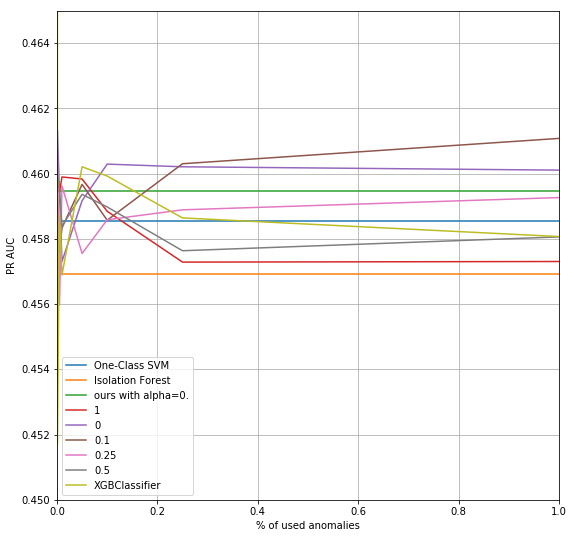

In [172]:
plot_for_comparison(pr_s, all_methods, ylabel="PR AUC",y_lim=(0.45,0.465))

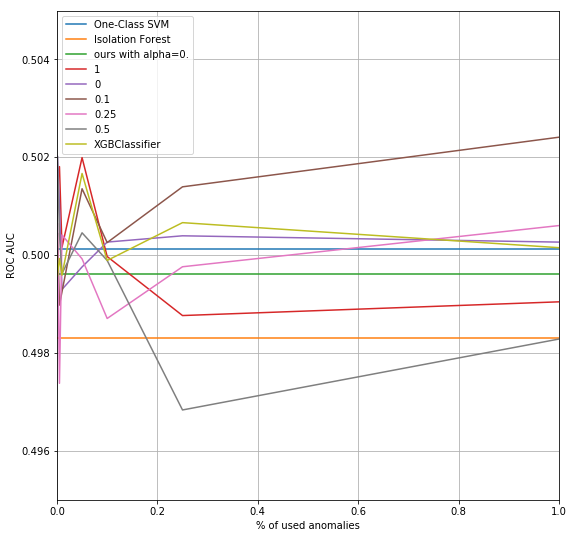

In [175]:
plot_for_comparison(roc_s, all_methods, ylabel="ROC AUC", y_lim=(0.495,0.505))

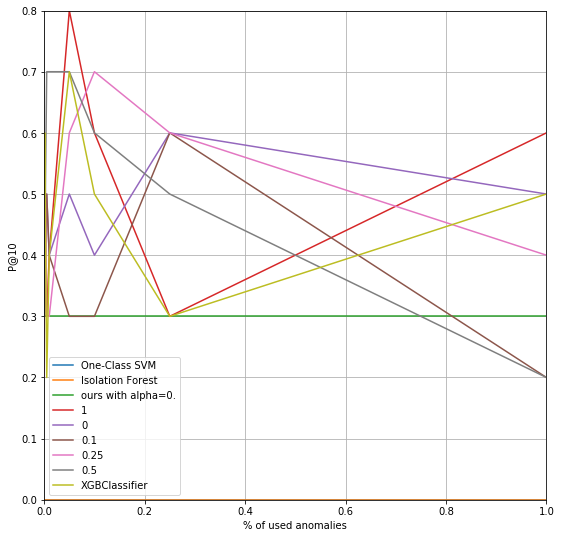

In [164]:
plot_for_comparison(p_at_10_s, all_methods, ylabel="P@10", y_lim=(0.,0.8))

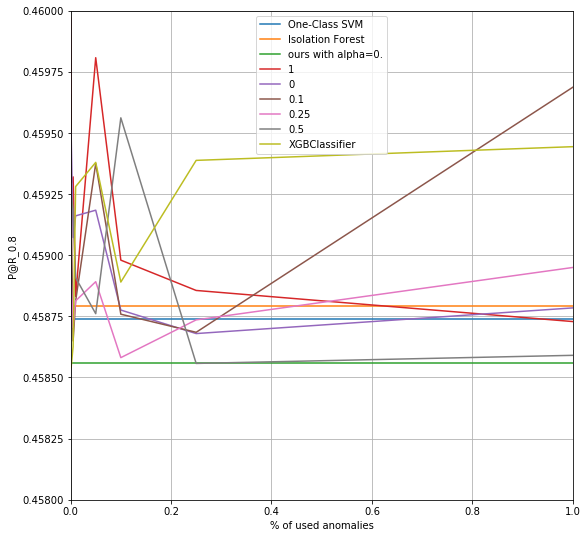

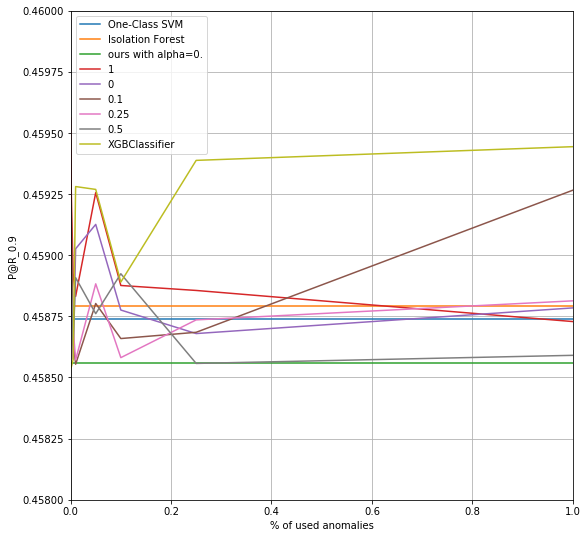

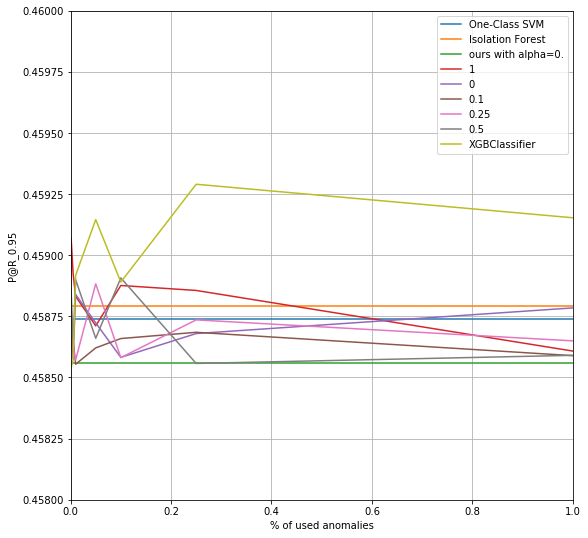

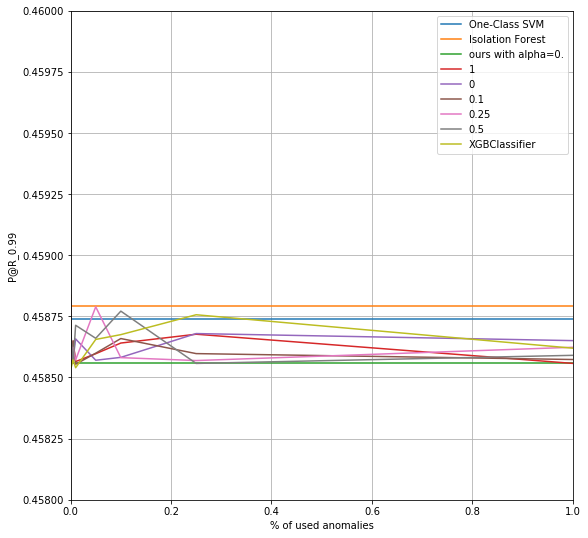

In [169]:
for key in ours_p_at_r.keys():
    plot_for_comparison(p_at_r_s[key], all_methods, ylabel="P@R_" + str(key), y_lim=(0.458,0.46))